<a href="https://colab.research.google.com/github/jnpos/group8_ECG/blob/Development/ECG_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!git clone https://github.com/jveenland/tm10007_ml.git

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.


In [29]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
import zipfile
import os
import pandas as pd

# Metrics
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import preprocessing

In [30]:
with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 827
The number of columns: 9001


**Split input and output data:**

In [31]:
# Find column with label 
bool_cols = [col for col in data 
             if np.isin(data[col].dropna().unique(), [0, 1]).all()]
loc_label = data.columns.get_loc('label')

# Determine data and output 
y = data['label']
x = pd.DataFrame()
x = data.drop(data.columns[loc_label],axis=1)


**Check for missing data & remove samples with missing data:**

In [32]:
# Delete patients (samples) with missing data
deleted_patients = []
zero_samples = []
num_zeros = []
zero_counts = []
eenvariabele = []
print(len(x))
for i in range(len(x)):
  num_zeros = (x.iloc[i] == 0).sum()
  if (num_zeros/750 >= 1) & (num_zeros%750 == 0):                   # met deze regel controleer je of het aantal 0'en overeenkomt met het aantal frequentie features dat in 1 lead zit
    deleted_patients.append(i)
    zero_samples.append("Sample_" + str(i))
    zero_counts.append(num_zeros)

x_dropped = x.drop(deleted_patients)
x_dropped = x_dropped.reset_index(drop=True)
y_dropped = y.drop(deleted_patients)
y_dropped = y_dropped.reset_index(drop=True)
table = pd.DataFrame({'Sample ID': zero_samples, 'Zero count': zero_counts})

print(table)
print(f'The number of samples: {len(x_dropped.index)}')
print(f'The number of columns: {len(x_dropped.columns)}')

827
     Sample ID  Zero count
0   Sample_177         750
1   Sample_251         750
2   Sample_269         750
3   Sample_321         750
4   Sample_323         750
5   Sample_385         750
6   Sample_434         750
7   Sample_446         750
8   Sample_537         750
9   Sample_542         750
10  Sample_575         750
11  Sample_601         750
12  Sample_784         750
13  Sample_790         750
The number of samples: 813
The number of columns: 9000


**Split data in train and test:**

In [33]:
# Split test and trainingsdata 
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_dropped, y_dropped,test_size=0.25,random_state=0,stratify=y_dropped)

**Scaling:**

In [34]:
# SCALEN
scaler = preprocessing.RobustScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train))

# Niet fitten op test, alleen toepassen


**Checking if data is normally distributed:**


In [35]:
# Checking if data is normally distributed  

from scipy.stats import shapiro  
shapiro(x_train)

amount_normallydistributed = 0
for column in x_train.columns:
  result = shapiro(x_train[column])
  normallydistributed = result.pvalue > 0.05
  amount_normallydistributed += normallydistributed 
  
print(amount_normallydistributed, "features are normally distributed features")


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0 features are normally distributed features


**Feature selection:**

In [36]:
# Feature selection

# Univariate & f_classif
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif,k="all")
selector.fit(x_train,y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

dataframe = pd.DataFrame()
dataframe = selector.pvalues_

print(len(selector.pvalues_[selector.pvalues_<0.05]))

fs = SelectKBest(score_func=f_classif, k=len(selector.pvalues_[selector.pvalues_<0.05]))
X_univariate = fs.fit_transform(x_train, y_train)
print(f'result univariate: {X_univariate.shape}')

# Elastic net
from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.feature_selection import SelectFromModel

#for i in np.arange(0.02,1,0.02):
#regr = ElasticNetCV(cv=5, random_state=0)
#regr.fit(x_train, y_train)
#print(regr.alpha_)
#print(regr.intercept_)
regr_alpha_ = 0.3858647907662583

ENreg = ElasticNet(alpha=regr_alpha_, l1_ratio=0.05).fit(x_train,y_train)
model_ENreg = SelectFromModel(ENreg, prefit=True)
x_ENreg = model_ENreg.transform(x_train)
#print(f'result Elastic Net: {x_ENreg.shape}, met als i:{i}')
print(f'result Elastic Net: {x_ENreg.shape}')


855
result univariate: (609, 855)
result Elastic Net: (609, 172)


# **PCA for decision tree features:**

In [19]:
# PCA for decision tree features for x_univariate
X_univariate = pd.DataFrame(X_univariate)
n_samples = len(X_univariate)
n_features = len(X_univariate.columns)
n_features = min((n_samples//2), n_features)

p = PCA(n_components=n_features)
p = p.fit(X_univariate)
x_pca = p.transform(X_univariate)

print(f'result pca: {x_pca.shape}')

result pca: (609, 304)


**Learning curves with F2 without hyperparameter optimization**

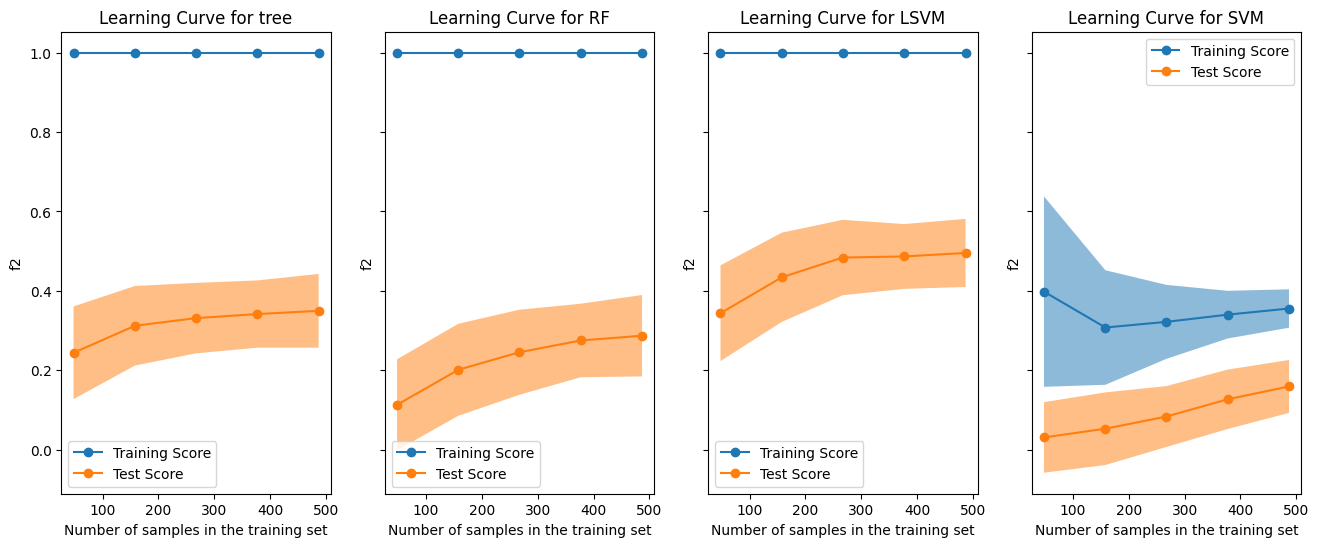

In [20]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import fbeta_score, make_scorer

# define f_beta as a scorer
# beta < 1 lends more weight to precision, while beta > 1 favors recall
f_beta = make_scorer(fbeta_score, beta=2)

tree = tree.DecisionTreeClassifier(random_state=0)
l_svm = LinearSVC(random_state=0)
svm = svm.SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params_tree = {
    "X": x_pca,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")





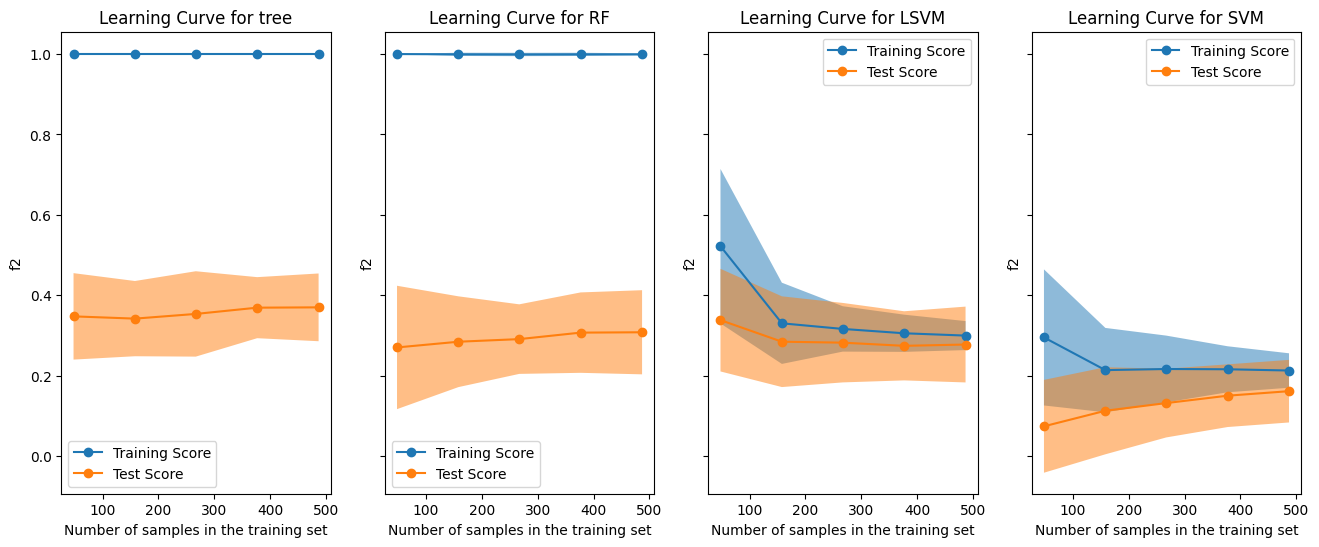

In [21]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import fbeta_score, make_scorer

# define f_beta as a scorer
# beta < 1 lends more weight to precision, while beta > 1 favors recall
f_beta = make_scorer(fbeta_score, beta=2)

tree = tree.DecisionTreeClassifier(random_state=0)
l_svm = LinearSVC(random_state=0)
svm = svm.SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)

common_params = {
    "X": x_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params_tree = {
    "X": x_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")


**Learning curves with F2 and hyperparameter optimization**

KeyboardInterrupt: ignored

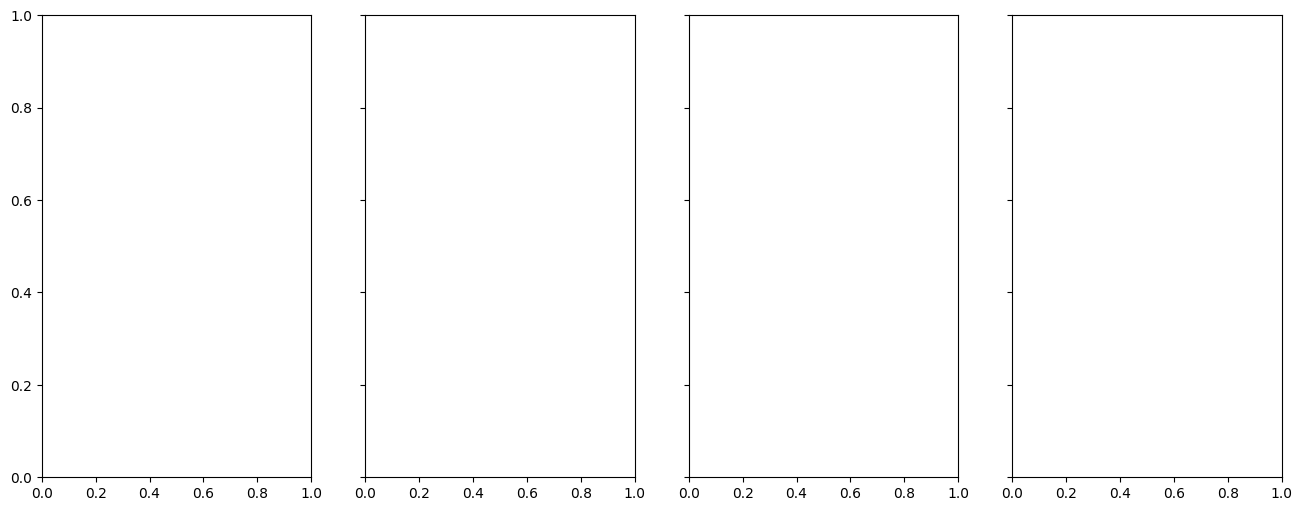

In [37]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import fbeta_score, make_scorer

# define f_beta as a scorer
# beta < 1 lends more weight to precision, while beta > 1 favors recall
f_beta = make_scorer(fbeta_score, beta=2)

tree = DecisionTreeClassifier(random_state=0, splitter='best', min_weight_fraction_leaf=0.16666666666666666, min_samples_split=2, min_samples_leaf=6, max_features=None, criterion='entropy', class_weight='balanced')
l_svm = LinearSVC(random_state=0, tol=100.0, penalty='l1', loss='squared_hinge', intercept_scaling=9, fit_intercept=True, dual=False, class_weight='balanced', C=0.01)
svm = svm.SVC(random_state=0, tol=10.0, shrinking=False, probability=True, kernel='poly', gamma='scale', degree=0, coef0=-5, class_weight='balanced', cache_size=363, C=0.001)
# Moet nog aangepast worden naar goede hyperparameters (icm met X_univariate) random_state=0:
rf = RandomForestClassifier(random_state=0, warm_start=True, oob_score=True, n_estimators=555, min_weight_fraction_leaf=0.1875, min_samples_split=4, min_samples_leaf=8, max_features=None, criterion='entropy', class_weight='balanced', bootstrap=True)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params_tree = {
    "X": x_pca,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

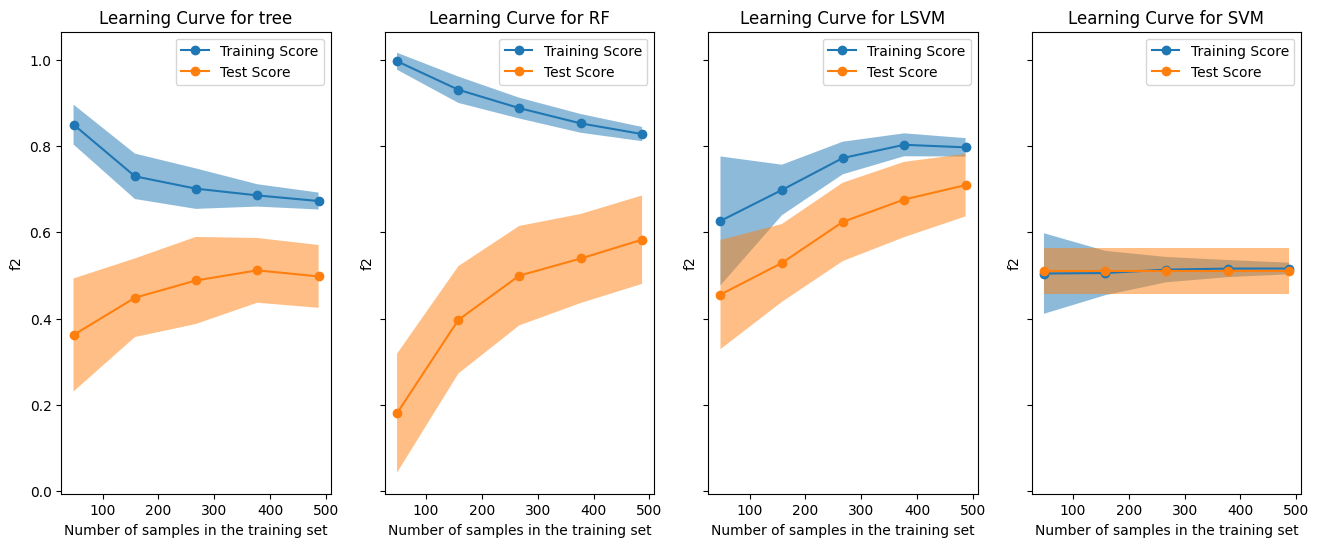

In [38]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import fbeta_score, make_scorer

# define f_beta as a scorer
# beta < 1 lends more weight to precision, while beta > 1 favors recall
f_beta = make_scorer(fbeta_score, beta=2)

tree = DecisionTreeClassifier(random_state=0, splitter='best', min_weight_fraction_leaf=0.16666666666666666, min_samples_split=2, min_samples_leaf=6, max_features=None, criterion='entropy', class_weight='balanced')
l_svm = LinearSVC(random_state=0, tol=100.0, penalty='l1', loss='squared_hinge', intercept_scaling=9, fit_intercept=True, dual=False, class_weight='balanced', C=0.01)
#moeten nog aangepast worden naar goede hyperparameters (met goede X_ENreg):
svm = svm.SVC(random_state=0, tol=10.0, shrinking=False, probability=True, kernel='poly', gamma='scale', degree=0, coef0=-5, class_weight='balanced', cache_size=363, C=0.001)
#Deze staat al wel goed:
rf = RandomForestClassifier(random_state=0, warm_start=True, oob_score=True, n_estimators=795, min_weight_fraction_leaf=0.14583333333333331, min_samples_split=9, min_samples_leaf=5, max_features='log2', criterion='gini', class_weight='balanced', bootstrap=True)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)

common_params = {
    "X": x_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}
title = ['tree', 'RF', 'LSVM', 'SVM']

common_params_tree = {
    "X": x_ENreg,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f2",
    "scoring": f_beta
}

LearningCurveDisplay.from_estimator(tree, **common_params_tree, ax=ax[0])
handles, label = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ["Training Score", "Test Score"])
ax[0].set_title(f"Learning Curve for {title[0]}")

for ax_idx, estimator in enumerate([rf, l_svm, svm],1):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")

Outer cross validation

In [ ]:
#univariate LSM bepalen wat f2 scores zijn op testset (met inner of outer kruisvalidatie met test set)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_dropped, y_dropped,test_size=0.25,random_state=0,stratify=y_dropped)
